Now that we've created a predictive model we can apply this model to a new set of molecules. In many cases, we will build a predictive model based on literature data, then apply that model to a set of molecules that we want to screen.  The molecules we want to screen may come from an internal database or from a commercially available screening collection.  As an example, we will use the predictive model we created to screen a small sample of 100,000 compounds from the ZINC database.  

One potential source of difficulty when carrying out a virtual screen is the presence of molecules which have the potential to interfere with biological assays.  Over the last 25 years, many groups have developed sets of computational filters to identify potentially reactive or problematic molecules.  Several of these rule sets, which are encoded as SMARTS strings have been collected by the group that curates the ChEMBL database.  These rule sets have been made avaiable through a Python script called rd_filters.py.  In this example, we will use rd_filters.py to identify potentially problematic molecules in our set of 100,000 molecules from the ZINC database.  

**IMPORTANT**  In order to run this notebook you must install the rdfiters script which can be downloaded from https://github.com/PatWalters/rd_filters the script rd_filters must be in your path. 

The rd_filters script can be called as follows. 

In [1]:
!pip install git+https://github.com/PatWalters/rd_filters.git

  Cloning https://github.com/PatWalters/rd_filters.git to /tmp/pip-req-build-e5icdaa4
  Created wheel for rd-filters: filename=rd_filters-0.1-py3-none-any.whl size=33902 sha256=79e4557d2ca9128780436a3338a57af40c46e1483b97adda3f3d2ca19d6c5aa9
  Stored in directory: /tmp/pip-ephem-wheel-cache-t104at88/wheels/8e/02/55/698b62161cc959f7204f1a49cb332450c53f3de4fecd51c064
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13705 sha256=69e92f8bb9d60827918ec224c8c8fb2e17837dcc512ff2bf8980aadf28c65548
  Stored in directory: /root/.cache/pip/wheels/3f/2a/fa/4d7a888e69774d5e6e855d190a8a51b357d77cc05eb1c097c9
Successfully built rd-filters docopt


In [2]:
!rd_filters -h

Usage:
rd_filters filter --in INPUT_FILE --prefix PREFIX [--rules RULES_FILE_NAME] [--alerts ALERT_FILE_NAME][--np NUM_CORES]
rd_filters template --out TEMPLATE_FILE [--rules RULES_FILE_NAME]

Options:
--in INPUT_FILE input file name
--prefix PREFIX prefix for output file names
--rules RULES_FILE_NAME name of the rules JSON file
--alerts ALERTS_FILE_NAME name of the structural alerts file
--np NUM_CORES the number of cpu cores to use (default is all)
--out TEMPLATE_FILE parameter template file name


To call the script on our input file, which is called zinc_100k.smi we can specify the input file and a prefix for output file names. 

In [3]:
!rd_filters filter --in zinc_100k.smi --prefix zinc

using 32 cores
Using alerts from Inpharmatica
Wrote SMILES for molecules passing filters to zinc.smi
Wrote detailed data to zinc.csv
67885 of 100000 passed filters 67.9%
Elapsed time 3.44 seconds


The output above indicates the following. 
* The script runs in parallel across multiple cores, the number of cores can be selected with the "-np" flag
* The script is using the "Inpharmatica" set of alerts. It has 7 other alert sets available.  Please see the rd_filters.py documentaiton for more information
* SMILES for the molecules passing the filters was written to a file called zinc.smi.  We will use this as the input when we use the predictive model.
* Detailed information on which compounds triggered particular structural alerts was written to a file called zinc.csv. 
* 68% of the structures passed the filters

It is informative to take a look at the reasons molecules were rejected.  This can let us know whether we need to adjust any of the filters. 

In [4]:
import pandas as pd

In [5]:
df = pd.read_csv("zinc.csv")

In [6]:
df.head()

,SMILES,NAME,FILTER,MW,LogP,HBD,HBA,TPSA,Rot
0,CN(CCO)C[C@@H](O)Cn1cnc2c1c(=O)n(C)c(=O)n2C,ZINC000000000843,Filter82_pyridinium > 0,311.342,-2.2813,2,9,105.52,6
1,O=c1[nH]c(=O)n([C@@H]2C[C@@H](O)[C@H](CO)O2)cc1Br,ZINC000000001063,Filter82_pyridinium > 0,307.100,-1.0602,3,6,104.55,2
2,Cn1c2ncn(CC(=O)N3CCOCC3)c2c(=O)n(C)c1=O,ZINC000000003942,Filter82_pyridinium > 0,307.310,-1.7075,0,8,91.36,2
3,CN1C(=O)C[C@H](N2CCN(C(=O)CN3CCCC3)CC2)C1=O,ZINC000000036436,OK,308.382,-1.0163,0,5,64.17,3
4,CC(=O)NC[C@H](O)[C@H]1O[C@H]2OC(C)(C)O[C@H]2[C...,ZINC000000041101,OK,302.327,-1.1355,3,6,106.12,4


We can use the Counter class from the Python "collections" library to identify which filters were responsible for removing the largest number of molecules.

In [7]:
from collections import Counter

count_list = list(Counter(df.FILTER).items())
count_df = pd.DataFrame(count_list, columns=["Rule", "Count"])
count_df.sort_values("Count", inplace=True, ascending=False)
count_df.head()

,Rule,Count
1,OK,68611
6,Filter41_12_dicarbonyl > 0,19330
0,Filter82_pyridinium > 0,7544
9,Filter93_acetyl_urea > 0,1541
10,Filter78_bicyclic_Imide > 0,825


The largest number of molecules (19,330) were rejected because they contained a 1,2 dicarbonyl group.  Molecules of this type have a tendency to act a Michael Acceptors and may reactive with nucleophilic protein residues such as serine and cysteine. Let's take a look at a few of these molecules.  

In [8]:
smiles_list = df[df.FILTER == "Filter41_12_dicarbonyl > 0"].SMILES[:10]

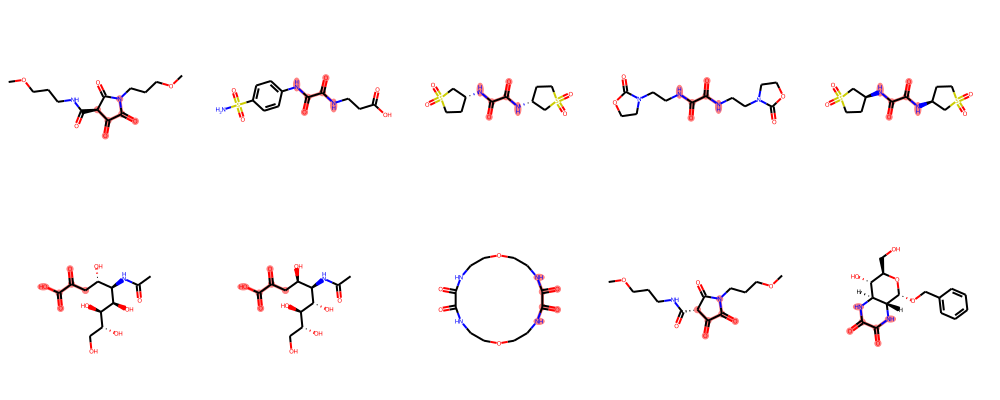

In [9]:
from rdkit import Chem
from rdkit.Chem import Draw

mol_list = [Chem.MolFromSmiles(x) for x in smiles_list]
dicarbonyl = Chem.MolFromSmarts("*C(=O)C(=O)*")
match_list = [mol.GetSubstructMatch(dicarbonyl) for mol in mol_list]
Draw.MolsToGridImage(mol_list, highlightAtomLists=match_list, molsPerRow=5)

As we can see above, the molecules do indeed have dicarbonyl groups.  If we wanted to we could similarly evaluate other filters.